<a href="https://colab.research.google.com/github/VitorPaes/hackathon_stn/blob/master/Hackathon_std.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de recomendação para micro e pequenas empresas de turismo

Desafio Hackathon Data Challenge Santander
02/08/2020

Time 35
1. Amanda
1. Hermes
1. Paola
1. Vinícius
1. Vitor


# Objetivo
Desenvolver um sistema de recomendação para colaborar com os negócios das micro e pequenas empresas do setor de turismo afetadas pela COVID-19, que já tenham sido certificadas com o Selo Turismo Responsável.

# Contextualização


## Planilha com estatísticas básicas de turismo 2018

O setor turístico brasileiro vinha em franco crescimento no século XXI. Motivos para isso são maior desenvolvimento, estruturação e incentivos, eventos, tais como Pan-Americano, Olimpíada e Copa do Mundo, globalização e popularização do país como destino por países da Europa.

Uma forma de se ver isso é através dos [dados](http://dadosefatos.turismo.gov.br/images/demanda/Estatisticas_Basicas_2017_2018.xlsx) fornecidos pelo Ministério do Turismo em 2018

#(TODO: JUSTIFICAR COM DADOS GRAFICOS DESSAS TABELAS)


In [1]:
url = 'http://dadosefatos.turismo.gov.br/images/demanda/Estatisticas_Basicas_2017_2018.xlsx'

import pandas as pd

DF_list = pd.read_excel(url, None)

df = DF_list['5.2 Oferta hoteleira'].iloc[6:39, 0:10]
df.columns = ["Local","MeioHospedagem_2016","UnidHab_2016","Leitos_2016",
              "MeioHospedagem_2017","UnidHab_2017","Leitos_2017",
              "MeioHospedagem_2018","UnidHab_2018","Leitos_2018"]

for col in list(df.columns):
  try:
    df[col] = df[col].str.strip()
  except:
    pass

df["GeoClass"] = "Estado"
df["GeoClass"].iloc[0] = "País"
df["GeoClass"].loc[df["Local"].isin(["Norte", "Nordeste", "Sudeste",
                                     "Sul", "Centro-Oeste"])] = "Região"


## Selo turismo responsável 
O Poder Executivo está tentando formas de tratar a problemática do turismo pós-COVID. Um dessas ações foi a criação do Selo Turismo Responsável. Este é uma certificação concedida pelo Governo Federal aos empreendimentos que seguem os protocolos estabelecidos para prevenção da COVID-19.

Tais empresas poderiam ser o espaço amostral para serem selecionadas para um sistema de recomendação, pois os proprietários estão conscientes da problemática da COVID-19.

Os [dados](http://www.turismo.gov.br/seloresponsavel/dados/TurismoResponsavelDadosAbertos.csv) são abertos e podem ser consultados online através do site do ministério do turismo.

Nota-se predomínio dos estados do Sudeste, provável causa da maior população dessa região. Também há presença forte de estados do Sul, possível que seja devido à maior integração do setor turístico nessa região. A seguir vem os estados do Nordeste, um típico destino turístico nacional.

In [2]:
url = 'http://www.turismo.gov.br/seloresponsavel/dados/TurismoResponsavelDadosAbertos.csv'  # Turismo responsavel pos-covid
df = pd.read_csv(url, header=5, sep=";")
df["UF"].value_counts()


São Paulo              2836
Rio de Janeiro         1802
Minas Gerais           1056
Bahia                   872
Rio Grande do Sul       652
Santa Catarina          581
Paraná                  572
Rio Grande do Norte     553
Pernambuco              507
Ceará                   452
Alagoas                 445
Maranhão                294
Espírito Santo          226
Goiás                   216
Pará                    159
Paraíba                 140
Mato Grosso do Sul      138
Distrito Federal        137
Amazonas                128
Mato Grosso             116
Sergipe                 108
Piauí                    93
Tocantins                47
Rondônia                 29
Roraima                  15
Amapá                     8
Acre                      4
Name: UF, dtype: int64

Observa-se também predomínio das Agências de Turismo e hospedagens nas empresas credenciadas.

In [3]:
df["Atividade"].value_counts()

Agência de Turismo                                                  4405
Meio de Hospedagem                                                  3639
Transportadora Turística                                            1471
Restaurante, Cafeteria, Bar e Similares                              845
Prestador Especializado em Segmentos Turísticos                      591
Organizadora de Eventos                                              450
Guia de Turismo                                                      271
Prestador de Infraestrutura de Apoio para Eventos                    142
Locadora de Veículos para Turistas                                   135
Parque Aquático e Empreendimento de Lazer                             67
Acampamento Turístico                                                 45
Parque Temático                                                       44
Empreendimento de Apoio ao Turismo Náutico ou à Pesca Desportiva      31
Centro de Convenções                               

In [4]:
df.groupby(by=["UF", "Atividade"]).count().iloc[:,0]

UF         Atividade                                              
Acre       Agência de Turismo                                           2
           Restaurante, Cafeteria, Bar e Similares                      2
Alagoas    Acampamento Turístico                                        1
           Agência de Turismo                                         108
           Casa de Espetáculos e Equipamento de Animação Turística      1
                                                                     ... 
Tocantins  Organizadora de Eventos                                      1
           Prestador Especializado em Segmentos Turísticos              3
           Prestador de Infraestrutura de Apoio para Eventos            1
           Restaurante, Cafeteria, Bar e Similares                      2
           Transportadora Turística                                     2
Name: Município, Length: 295, dtype: int64

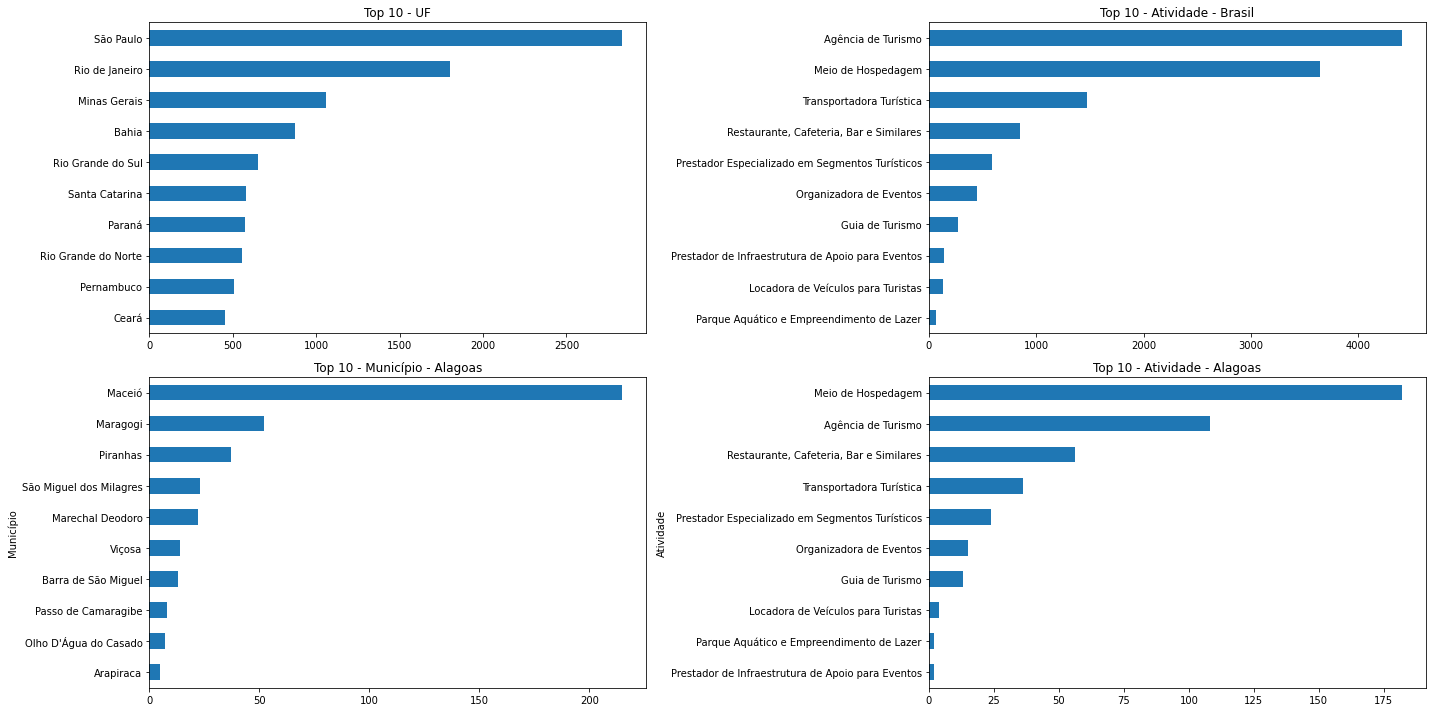

In [5]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(20,10))
col = "UF"
df[col].value_counts().nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[0,0],
                                          title='Top 10 - '+col)


col = "Atividade"
df[col].value_counts().nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[0,1],
                                          title='Top 10 - '+col+" - Brasil")

df.groupby(by=["UF", col]).count().iloc[:,0].loc['Alagoas'].nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[1,1],
                                          title='Top 10 - '+col+" - Alagoas")

col = "Município"
df.groupby(by=["UF", col]).count().iloc[:,0].loc['Alagoas'].nlargest(10).plot.barh(x=col,
                                          legend=False,
                                          ax=axs[1,0],
                                          title='Top 10 - '+col+" - Alagoas")


axs[0,0].invert_yaxis()
axs[0,1].invert_yaxis()
axs[1,0].invert_yaxis()
axs[1,1].invert_yaxis()

fig.tight_layout()

In [6]:
# Dashboards
!pip install plotly==4.9.0

# Static figures to show on GitHub
!pip install kaleido==0.0.1
!pip install psutil==5.7.2

In [7]:
import plotly.express as px
fig = px.treemap(df, path=['UF'], 
                 color_continuous_scale='RdBu',
                 title='Empresas com Selo Turismo Responsável por UF')
fig.show()

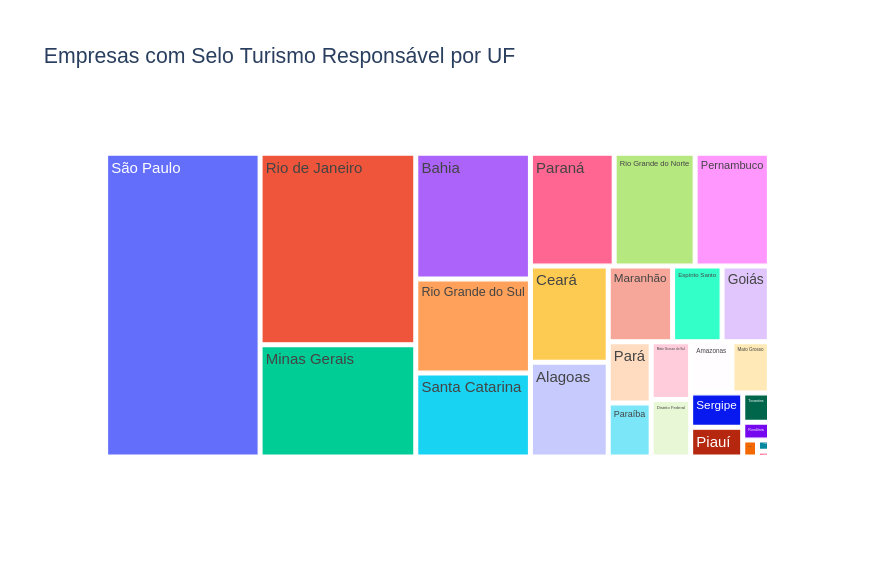

In [8]:
fig.show('png', scale=1.25)  # static, to show on Github

In [9]:
fig = px.treemap(df, path=['Atividade'], 
                 color_continuous_scale='RdBu',
                 title='Empresas com Selo Turismo Responsável por Atividade')
fig.show()

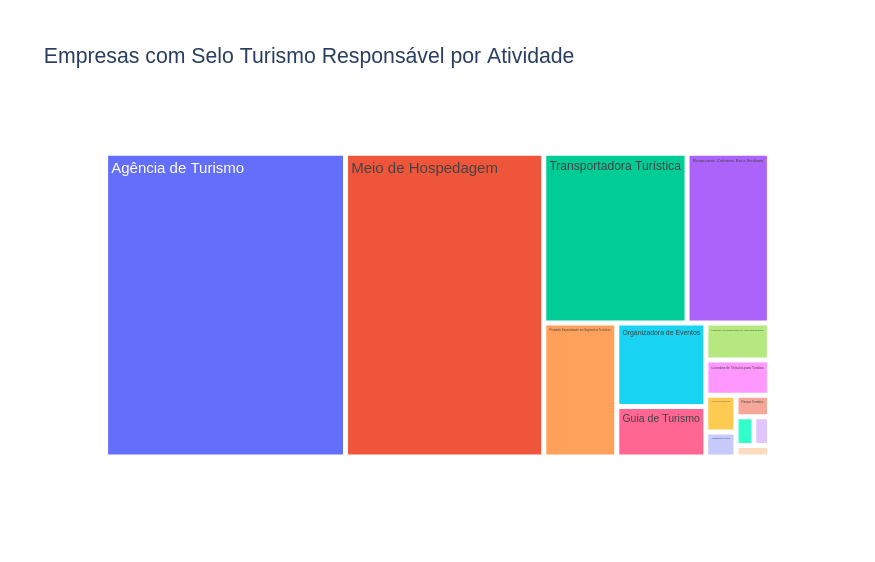

In [10]:
fig.show('png', scale=1.25)   # static, to show on Github

## Tableau brasil.io

A plataforma [Brasil.io](https://brasil.io/home/) é uma força tarefa de 40 voluntários que compila e disponibiliza dados da Covid-19 atualizados diariamente com boletins das 27 Secretarias Estaduais de Saúde. A seguir pode ser visto um exemplo de visualização dos casos para o estado do Alagoas.

O monitoramento dos dados da COVID é essencial para estabelecer medidas preventivas e corretivas de combate à disseminação da doença. O uso de uma ferramenta visual como essa possibilita ao usuário identificar os riscos associados a uma eventual viagem para certos destinos e deve ser ativamente monitorado pelo provável turista.

In [11]:
%%html
<div class='tableauPlaceholder' id='viz1596311061648' style='position: relative'><noscript>
  <a href='#'>
    <img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas&#47;1_rss.png' style='border: none' />
    </a></noscript>
  <object class='tableauViz'  style='display:none;'>
    <param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' />
  <param name='embed_code_version' value='3' />
  <param name='path' value='views&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas?:language=pt&amp;:embed=y&amp;:display_count=y' />
  <param name='toolbar' value='yes' />
  <param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Co&#47;Covid-19Alagoas&#47;MonitorCovid-19-Alagoas&#47;1.png' />
  <param name='animate_transition' value='yes' />
  <param name='display_static_image' value='yes' />
  <param name='display_spinner' value='yes' />
  <param name='display_overlay' value='yes' />
  <param name='display_count' value='yes' />
  <param name='language' value='pt' />
  </object></div>
  <script type='text/javascript'>
  var divElement = document.getElementById('viz1596311061648');
  var vizElement = divElement.getElementsByTagName('object')[0];
  if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';
  vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} 
  else if ( divElement.offsetWidth > 500 ) 
  { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';}
   else { vizElement.style.width='100%';vizElement.style.height='1227px';}
  var scriptElement = document.createElement('script');
  scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';
  vizElement.parentNode.insertBefore(scriptElement, vizElement);
  </script>

Visualização estática para o GitHub

![](https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/Monitor%20Covid-19%20-%20Alagoas.png)

## Dados voo (Hermes)

## Caged
O [Caged ](http://pdet.mte.gov.br/novo-caged) faz parte do Programa de Disseminação das Estatísticas do Trabalho do Ministério do Trabalho e fornece dados de desemprego. Pode se monitorar os efeitos da pandemia ao se analisar os saldos de contratações vs demissões no ano de 2020.

A problemática do setor de turismo é evidenciada, pois foram extintos 280.017 empregos no setor de Alojamento e alimentação no Brasil apenas em 2020.

Ao se observar os estados mais afetados, novamente se constatada a presença dos estados do Sudeste, Sul e Nordeste. O que corrobora que esses locais concentram o turismo nacional.

In [12]:
url = 'https://github.com/VitorPaes/hackathon_stn/blob/master/dataset/2006_dadosCaged.xlsx?raw=true'
DF_list = pd.read_excel(url, None)


Saldo acumulado 2020:  -280017


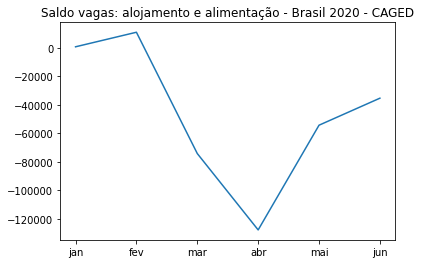

In [13]:
import numpy as np
df = DF_list['Tabela 6'].iloc[4:33, 1:131]
df.columns = df.iloc[0]
df.drop(df.index[0],inplace=True)
df.index = df.iloc[:,0]
df.columns = df.columns.fillna('to_drop')
df.drop('to_drop', axis = 1, inplace = True)

df_red = df.loc[["Alojamento e alimentação"]].drop(columns=["Admissões", "Estoque", "Desligamentos", "Variação Relativa (%)"])
df_red.columns=["jan","fev","mar","abr","mai","jun","jul","ago","set","out","nov","dez",2020]
df_red.iloc[0,6:12]=np.nan
df_red = df_red.T
df_red
plt.plot(df_red["Alojamento e alimentação"].iloc[0:6])
plt.title("Saldo vagas: alojamento e alimentação - Brasil 2020 - CAGED");
print("Saldo acumulado 2020: ", int(df_red.min()))

In [14]:
df = DF_list['Tabela 4'].iloc[4:33, 1:31]
df.columns = df.iloc[0]
df.drop(df.index[0],inplace=True)
df.index = df.iloc[:,0]
df.columns = df.columns.fillna('to_drop')
df.drop('to_drop', axis = 1, inplace = True)
df.loc["Alojamento e alimentação"].sort_values()

4
Total                  -35340
São Paulo              -10412
Rio de Janeiro          -6726
Minas Gerais            -3348
Paraná                  -2102
Rio Grande do Sul       -1778
Bahia                   -1652
Santa Catarina          -1577
Goiás                   -1342
Distrito Federal        -1068
Pernambuco              -1001
Espírito Santo           -705
Ceará                    -590
Alagoas                  -475
Rio Grande do Norte      -408
Mato Grosso              -363
Piauí                    -288
Mato Grosso do Sul       -284
Sergipe                  -247
Rondônia                 -222
Paraíba                  -159
Maranhão                 -159
Pará                     -142
Amazonas                 -106
Tocantins                 -59
Roraima                   -49
Acre                      -48
Amapá                     -29
Não identificado           -1
Name: Alojamento e alimentação, dtype: object

# Sistema de recomendação

Uma forma de fomentar o turismo nessas regiões e colaborar para as micro e pequena empresas reagirem ao pós-pandemia é propor serviços que recomendem destinos nacionais aos usuários.

Para iniciar uma base de dados para um sistema de recomendação, foram gerados 50 nomes aleatórios na [plataforma](http://listofrandomnames.com/index.cfm?generated).

A pesquisa da [demanda turística internacional de 2018](http://dadosefatos.turismo.gov.br/2016-02-04-11-54-03/demanda-tur%C3%ADstica-internacional.html) foi conduzida pelo Ministério do Turismo, com entrevista direta no momento do término da viagem (aeroportos, fronteiras terrestres) com 39,811 turistas durante uma-duas semanas em diferentes períodos do ano para mitigar os efeitos de sazonalidade. Este dado foi usado como entrada para estimar as distribuições de probabilidade de motivo principal da viagem, motivação da viagem de lazer e hospedagens.
Apresenta-se como limitação ter considerado um dado internacional, pois a distribuição da demanda doméstica provavelmente será diferente e tal demanda é consideravelmente maior. Contudo, utilizou-se esse dado por não dispor de dados de demanda turística nacional do Ministério do Turismo posteriores a 2012.

Probabilidades de
* motivo principal da viagem
* motivação da viagem de lazer
* tipos de hospedagem


In [15]:
# Fonte: List of Random Names

nomes_lista = ["Winford", "Christal", "Ellamae", "Tammara", "Alisa",
"Jenise", "Markita","Marcela", "Catrina", "Armida",
"Alayna", "Diego", "Chasity", "Elina", "Neely",
"Darlene", "Raina", "Thu", "Wilton", "Floy",
"Carlita", "Jami", "Joye", "Luana", "Nikita",
"Jerome", "Otto", "Sherika", "Dena", "Bryon", "Ewa",
"Rosalva", "Roseline", "Suzan", "Deloris", "Jinny",
"Victorina", "Albertine", "Luanna", "Toby", "Kara",
"Shan", "Deane", "Sammy", "Ginger", "Audra",
"Dorinda", "Colene", "Anh", "Beatris"]


# Fonte: Demanda Turística Internacional 2018

motivo_lista = ["Lazer", "NegociosEventosConvencoes", "VisitarAmigosParentes",
                 "EstudoCursos", "Saude", "Religiao", "Compras", "Outros"]
motivo_prob = [0.588, 0.135, 0.241, 0.016, 0.004, 0.004, 0.001, 0.011]

hospedagem_lista = ["Hotel", "Casa_Amigo_Parente", "Casa_Alugada",
                    "Camping_Albergue", "CasaPropria", "Outros"]

hospedagem_prob = [0.488, 0.249, 0.159, 0.047, 0.027, 0.03]

lazer_lista = ["Sol_Praia", "Natureza_Ecoturismo_Aventura", "Cultura",
               "Esportes", "Diversao_Noturna", "ViagemIncentivo", "Outros"]
lazer_prob = [0.717, 0.163, 0.095, 0.016, 0.004, 0.002, 0.003]


In [16]:
import random

def gera_amostras(nomes_lista, motivo_lista, lazer_lista, hospedagem_lista,
                  motivo_prob, lazer_prob, hospedagem_prob,
                  num_simulations = 49):
  usuarios = []
  motivo_tipos = []
  lazer_tipos = []
  hospedagem_tipos =[]
  
  for i in range(num_simulations):
    usuarios.append({"id": i, "name": nomes_lista[i]})

    motivo_sample = random.choices(motivo_lista, motivo_prob)[0]
    motivo_tipos.append((i, motivo_sample))
    
    hospedagem_sample = random.choices(hospedagem_lista, hospedagem_prob)[0]
    hospedagem_tipos.append((i, hospedagem_sample))

    if motivo_sample == "Lazer":
      lazer_sample = random.choices(lazer_lista, lazer_prob)[0]
      lazer_tipos.append((i, random.choice(lazer_lista)))
    else:
      lazer_tipos.append((i, ""))
  
  
  return usuarios, motivo_tipos, hospedagem_tipos, lazer_tipos


# TODO
# ACRESCENTAR NA OU MULTIPLAS OPCOES
# num_options = [1, 2, 3]
# nomes_lista = ["João", "Pedro", "Arthur", "Clara", "Roberto", "Júlia",
#               "Amanda", "André", "Eduardo", "Rafael"]
  #for j in range(1,random.choice(num_options)):
  #  motivo_tipos.append((i, random.sample(motivo_lista,k=j)))
  #hospedagem_tipos.append((i,
  #                      random.sample(hospedagem_lista,
  #                                     k=random.choice(num_options))))
  #lazer_tipos.append((i,
  #                      random.sample(lazer_lista,
  #                                     k=random.choice(num_options))))
# lazer_prob = [0.459, 0.155, 0.106, 0.104, 0.038, 0.032]
                 #["Pizza", "Churrasco", "Lanche", "Padaria", "Japonesa",
                  #   "Frutos do Mar"]#, "NA"]

# TODO
# CONFERIR POR QUE NAO ESTA GERANDO PREDICAO

## TODO 
# DICIONARIO COM TERMOS SIMILARES
# ex: Ecoturismo: natureza


Para implementar o sistema de recomendação foram desenvolvidas algumas funções auxiliares:

* `interest_freq`: contabiliza a frequência que uma palavra ocorre;
* `interest_unique`: identifica e ordena palavras únicas, associando-as a usuários;
* `make_user_vector`: retorna vetor binário para relação usuário x interesse;
* `cosine_similarity`: compara a similiaridade entre dois usuários com uma métrica de coseno;
* `most_similar_users_to`: identifica usuários mais similares;
* `user_based_recommendations`: gera recomendações com base nos usuários mais similares;
* `most_popular_new_interests`: identifica os interesses novos mais populares;
* `recommendations`: faz a recomendação com vetor de probabilidades.

In [17]:
from collections import Counter
from collections import defaultdict

def interest_freq(interest_types, interest_name):
  interest_freq = Counter(word for user_id, interest in interest_types
                           for word in interest.lower().split())
  
  print("\nTipos de " + interest_name)
  
  for word, count in interest_freq.most_common():
    if count > 1:
        print(word, count)

  return interest_freq


def interest_unique(interest_types):
  user_ids_by_interest = defaultdict(list)
  interest_by_user_id = defaultdict(list)
  unique_interest = set()
  
  for user_id, interest in interest_types:
    user_ids_by_interest[interest].append(user_id)
    interest_by_user_id[user_id].append(interest)
    unique_interest.add(interest)

  unique_interest = sorted(list(unique_interest))

  return unique_interest, interest_by_user_id, user_ids_by_interest


def make_user_vector(user_id, interest_by_user_id, unique_interest):
    """
      Criar vetor para um determinado usuário (usuário x interesse)

      1 - Se o usuário tem
      0 - Contrário

    """
    return [1 if interest in interest_by_user_id[user_id]
            else 0 for interest in unique_interest]


def cosine_similarity(v, w):
  """
      Compara dois usuários    
  """
  return np.dot(v, w) / np.sqrt(np.dot(v, v) * np.dot(w, w))


def most_similar_users_to(user_id, users_sim_matrix):
    pairs = [(other_user_id, similarity)
            for other_user_id, similarity in enumerate(users_sim_matrix[user_id])
             if user_id != other_user_id and similarity > 0
            ]
    return sorted(pairs, key=lambda x: -x[1])


def user_based_recommendations(user_id, interest_by_user_id, unique_interest,
                               include_current_interests=False):
    """
        Gerar recomendação baseado nos usuários mais similares

    """

    # Usuários x interesses
    users_matrix = [make_user_vector(user, interest_by_user_id, unique_interest)
                for user in interest_by_user_id]
    # Similaridade
    users_sim_matrix = [[cosine_similarity(interest_vector_v, interest_vector_w) 
                     for interest_vector_w in users_matrix] 
                    for interest_vector_v in users_matrix]
    
    ## Usuários mais similares ao usuário
    # most_similar_users_to(0)
    
    ## Lista de interesses do usuário
    # print(interest_by_user_id[0])

    predictions = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id,
                                                           users_sim_matrix):
      for interest in interest_by_user_id[other_user_id]:
        # Para cada interesse soma-se a similaridade dos usuários mais proxímos
        predictions[interest] += similarity

    predictions = sorted(predictions.items(), key=lambda x: -x[1])

    if include_current_interests:
        return predictions
    
    
    # TODO: VERIFICAR por que não está retornando
     
    else:
        return [(prediction, round(score,2)) 
            for prediction, score in predictions
                if prediction not in interest_by_user_id[user_id]]

    


def most_popular_new_interests(user_interests, popular_interests, max_results=5):
    recommendations = [
        (interest, frequency)
        for interest, frequency in popular_interests.items()

        if interest not in user_interests
                      ]
    return sorted(recommendations[:max_results], key=lambda x: -x[1])


def recommendation(users, interest_by_user_id, user_sampled):
  most_common_interest = Counter(interest for user in users 
                            for interest in interest_by_user_id[user['id']])
  print("\nRecomendações para %s:: %s " 
      % (users[user_sampled]['name'],
         most_popular_new_interests(interest_by_user_id[user_sampled],
                                    most_common_interest)))
  # TODO remover print "" de tipos de lazer quando não for lazer

  return most_common_interest

Para testar, geram-se amostras e seleciona-se aleatoriamente um usuário.

In [18]:
num_simulations = len(nomes_lista)

(usuarios, motivo_tipos, hospedagem_tipos, lazer_tipos) = \
      gera_amostras(nomes_lista, motivo_lista, lazer_lista, hospedagem_lista,
                    motivo_prob, lazer_prob, hospedagem_prob,
                    num_simulations)
usuario_amostra = random.randint(0,num_simulations)

A seguir, observam-se as respostas mais frequentes, recomendações para o usuário e predição (motivo, interesse por lazer e hospedagem).

In [19]:
motivo_freq = interest_freq(motivo_tipos, 'motivo')
motivo_unico, motivo_por_id_usuario, id_usuario_por_motivo = interest_unique(motivo_tipos)
popular_motivo = recommendation(usuarios, motivo_por_id_usuario, usuario_amostra)

user_based_pred = user_based_recommendations(usuario_amostra,
                                             motivo_por_id_usuario, motivo_unico)
print("\nPredição para o usuário: ", user_based_pred)


Tipos de motivo
lazer 34
negocioseventosconvencoes 10
visitaramigosparentes 6

Recomendações para Darlene:: [('NegociosEventosConvencoes', 10), ('VisitarAmigosParentes', 6)] 

Predição para o usuário:  []


In [20]:
lazer_freq = interest_freq(lazer_tipos, 'lazer')
lazer_unico, lazer_por_id_usuario, id_usuario_por_lazer = interest_unique(lazer_tipos)
popular_lazer = recommendation(usuarios, lazer_por_id_usuario, usuario_amostra)

user_based_pred = user_based_recommendations(usuario_amostra,
                                             lazer_por_id_usuario, lazer_unico)
print("\nPredição para o usuário: ", user_based_pred)


Tipos de lazer
outros 7
diversao_noturna 6
natureza_ecoturismo_aventura 6
viagemincentivo 4
esportes 4
cultura 4
sol_praia 3

Recomendações para Darlene:: [('', 16), ('Diversao_Noturna', 6), ('Natureza_Ecoturismo_Aventura', 6), ('ViagemIncentivo', 4), ('Esportes', 4)] 

Predição para o usuário:  []


In [21]:
hospedagem_freq = interest_freq(hospedagem_tipos, 'hospedagem')
hospedagem_unico, hospedagem_por_id_usuario, id_usuario_por_hospedagem = interest_unique(hospedagem_tipos)
popular_hospedagem = recommendation(usuarios,
                                    hospedagem_por_id_usuario, usuario_amostra)

user_based_pred = user_based_recommendations(usuario_amostra,
                                             hospedagem_por_id_usuario,
                                             hospedagem_unico)
print("\nPredição para o usuário: ", user_based_pred)


Tipos de hospedagem
hotel 25
casa_amigo_parente 10
casa_alugada 9
camping_albergue 4
casapropria 2

Recomendações para Darlene:: [('Casa_Amigo_Parente', 10), ('Casa_Alugada', 9), ('Camping_Albergue', 4), ('CasaPropria', 2)] 

Predição para o usuário:  []


## Planilha de turismo do Alagoas

Em um primeiro momento, optou-se por limitar o estudo ao estado do Alagoas, tendo em vista que foi encontrada uma [base](https://) que permite testar o sistema de recomendação. 

# TODO inserir link

In [22]:
url = 'https://raw.githubusercontent.com/VitorPaes/hackathon_stn/master/dataset/convertcsv3.csv'
df = pd.read_csv(url, sep=";", encoding='latin')

for col in ['Nome', 'Município', "Segmento"]:
  df[col] = df[col].str.strip()

col = "Segmento"
df[col] = df[col].str.replace("Sol e Praia","Praia")


col = "Município"
df[col] = df[col].str.replace("-AL","")

col = "Distância da Capital (km)" 
df[col] = df[col].str.replace(",",".").astype('float')

col = "Tempo de condução estimado" 
df[col] = df[col].str.replace(".","")
df[col] = df[col].str.replace("minutos","min")
df[col] = df[col].str.replace(" ","")
df[col] = df[col].str.replace("he",":")

df[col] = df[col].str.replace(r"^([0-9]+)min","00:\\1")
df[col] = df[col].str.replace(r"([0-9]+)h$","\\1:00")
df[col] = df[col].str.replace("min","")
df[col] = df[col].str.replace("^([0-9]):","0\\1:")
df[col] = df[col].str.replace(":([0-9])$",":0\\1")

col = "Latitude" 
df[col] = df[col].astype('str').str.replace(".","")
df[col] = df[col].str.replace("^-9","-9.")
df[col] = df[col].str.replace("^-10","-10.").astype('float')

col = "Longitude"
df[col] = df[col].astype('str').str.replace(".","")
df[col] = df[col].str.replace("^-3","-3.").astype('float')

col = "Segmento"
df[col].value_counts()

Praia                        56
Histórico/Cultural           17
Ecoturismo/Aventura           6
Ecoturismo/Aventura/Praia     1
Name: Segmento, dtype: int64